# 1. Задача

### Выделить ключевые слова из запроса пользователя в соответствии с иерархической предметной областью.



Ограничения:

1. Слова должны находиться на одной ветке. Приэтом не допускается использование нескольких агрегаторов на **одном уровне.** 
2. Слова, лежащие даже в абсолютно разных ветках, могут быть очень похожи. Например, "ипотека" - "none" -  "агентские", "ипотека" - "агентские обязанности"; "онлайн", "офлайн"; "с господдержкой", "без господдержки"; и т.д.
3. От перестановки слов - ничего не ломается.
4. Допускаются опечатки до некоторого значения.
5. Если есть длинный ключ (), то он хуже обрабатывается базовыми методами, например, расстоянием Левенштейна. Очень маленькие слова также зависят от формы слова (план - планов - низкий Левенштейн).
6. В ключах могут быть уменьшенные синонимы.


# 2. Исходные данные и библиотеки

### Библиотеки

In [2]:
# %pip install requirements_main.txt

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from rapidfuzz import fuzz, process
from sklearn.model_selection import train_test_split
import optuna

from utils.config import levels
from utils.get_dynamic_query_list import *
from utils.fit_hierarchy import *
from utils.process_query import *

from warnings import filterwarnings
filterwarnings('ignore')

### Исходная иерархия:

In [4]:
with open('data/bank_hierarchy.json', 'r') as f:
    hierarchy = json.load(f)
    
hierarchy

{'Corporate': {'Вклады': {'None': {'None': {'None': ['Количество операций',
      'Сумма, млн ₽']}},
   'До востребования': {'None': {'None': ['Количество операций',
      'Сумма, млн ₽']},
    'Плавающая ставка': {'None': ['Количество операций', 'Сумма, млн ₽'],
     'Длинные': ['Количество операций', 'Сумма, млн ₽'],
     'Короткие': ['Количество операций', 'Сумма, млн ₽']},
    'Фиксированная ставка': {'None': ['Количество операций', 'Сумма, млн ₽'],
     'Длинные': ['Количество операций', 'Сумма, млн ₽'],
     'Короткие': ['Количество операций', 'Сумма, млн ₽']}},
   'Краткосрочные': {'None': {'None': ['Количество операций', 'Сумма, млн ₽']},
    'Плавающая ставка': {'None': ['Количество операций', 'Сумма, млн ₽'],
     'Длинные': ['Количество операций', 'Сумма, млн ₽'],
     'Короткие': ['Количество операций', 'Сумма, млн ₽']},
    'Фиксированная ставка': {'None': ['Количество операций', 'Сумма, млн ₽'],
     'Длинные': ['Количество операций', 'Сумма, млн ₽'],
     'Короткие': ['К

### Подгрузка данных и разделение на тренировочную и валидационную выборки

In [5]:
queries_df = pd.read_csv('data/queries.csv')
queries_df.head(2)

,text,keywords,k_count
0,Дай сводку: для sme.,SME,1
1,где презентацИя вЧЕрАшняЯ леЖИт?,NaN,0


In [6]:
queries_df.fillna('None', inplace=True)

In [ ]:
X = queries_df.copy()
X['keywords'] = X['keywords'].apply(lambda x: x.split(' | '))

X_train, X_val= train_test_split(X, train_size=0.8, stratify=X['k_count'], random_state=42)

In [9]:
X_val.shape[0]

240

In [11]:
X_train['k_count'].value_counts(normalize=True)

k_count
4    0.143156
1    0.143156
5    0.143156
2    0.143156
0    0.143156
6    0.142111
3    0.142111
Name: proportion, dtype: float64

In [ ]:
X_val['k_count'].value_counts(normalize=True)

k_count
3    0.145833
6    0.145833
1    0.141667
5    0.141667
0    0.141667
4    0.141667
2    0.141667
Name: proportion, dtype: float64

# 3. Описание алгоритма решения

### 1. fit_hierarchy

Сперва вытаскиваем из нашего дерева нормализованные ключевые слова, а также словарь типа "нормализованнео значение - ключ в исходнике". Так мы быстро можем собирать и валидировать ответ

### 2. process_query. Общее описание

Обработка запроса. Разделяется на два алгоритма: первый - long_fuzzy_match - обрабатывает ключи с двумя и более словами с помощью вложенных окон; второй - short_fuzzy_match - обрабатывает слова по одному, тем самым идеально подходит для однословных ключей.
<br><br>
После того, как алгоритмы вернули свои слова, они проходят проверку по контекстной матрице. Если проверка не пройдена, то запускается проверка по схожим словам (этот алгоритм решает проблему сильно похожих слов на разных ветках). В конце снова проверяется контекстная совместимость. 
<br><br>
На выход подается словарь с найденными значениями и уровнями, на которых нашлись эти значения.

### 2.1. long_fuzzy_match

Обработка ключей с двумя и более словами. Сначала по окну размером 5 выбираются кандидаты, которые вероятнее всего присутствуют. Для точности используется функция из библиотеки rapidfuzz fuzz.partial_token_set_ratio, которая дает высокий показатель схожести, если словосочетания имеют хотя бы какие-то похожие части. Для уточнения результата по первому окну проходимся окном меньшего размера с более точной функцией - fuzz.token_set_ratio.

### 2.2. short_fuzzy_match

Обработка однословных ключей. Обычный мэтч по словам. Остановился на jaro_winkler, т.к. дает высокий показатель для опечаток и перестановок букв слов.

### 2.3. update_similarity_matrix

Функция, наполняющая матрицу схожести слов. Схожесть вычисляем по расстоянию Дамерау-Левенштейна.

### 2.4. update_context_matrix

Функция, наполняющая контекстную матрицу. В нашем случае, считаем, что слова контекстно совместимы, если любое слово является потомком или родителем остальных (т.е. не допускаются слова с одного уровня).

### 2.5. build_path

Функция, составляющая запрос в виде словаря по уровням.

### 3. get_dynamic_query_list

Функция, возвращающая список из подходящих значений. Следует следующим требованиям:

1. Если какие-то значения пропущены, то берем первое значение не None, считая справа, и пытаемся восстановить всевозможные пути/комбинации до него.
2. Если не выбран драйвер, то выводятся оба списка.

### Плюсы алгоритма:

1. Работает быстрее LLM и тратит меньше ресурсов.
2. Настраиваемый под разные иерархии.
3. Настраиваемый под любую точность.
4. Обрабатывает случаи типа "агентские" - "агентские обязанности", "онлайн" - "офлайн" и т.д.
5. Справляется с любым порядком слов, знаками препинания и регистром.
6. Обнаруживает контекстные конфликты
7. Отлавливает "лишние" слова на мэтчах.

### Минусы алгоритма:

1. Требует настройки.
2. Ломается, если в иерархии два абсолютно одинаковых ключа.
3. Дилемма опечаток-лишних слов: если поставить низкий порог схожести для мэтчей и матрицы схожести, то в запрос включаются лишние слова, если поставить слишком высокий - даже формы слова перестают мэтчиться.
4. Не успел дописать поддержку синонимов через ;

### Решения проблема:

1. Подбор гиперпараметров под свою иерархию.
2. Как-то индексировать ключи и проводить поиск по ним, сверяться с контекстом.
3. Использовать в качестве синонимов все формы слов.

# 4. ShowCase - демонстрация: метрики, тестирование, UI

### Демонстрация UI

![](./data/screen1.png)

![](./data/screen2.png)

![](./data/screen3.png)

![](./data/screen4.png)

![](./data/screen5.png)

![](./data/screen6.png)

### Модельный вид решения

In [18]:
from utils.final_model import *

model = KeywordsQueryProcessor()
model.fit(hierarchy, levels)

model.transform('Что там по первичке ипотека?')


CHOSEN TERMS: ['первичка', 'ипотека']

FINAL TERMS: ['первичка', 'ипотека']


{'segment': 'None',
 'lvl_1': 'None',
 'lvl_2': 'Ипотека',
 'lvl_3': 'Первичка',
 'lvl_4': 'None',
 'driver_1': 'None'}

### Метрики:

* "Грубый" accuracy - правильно ли или неправильно составил запрос. Ключевая метрика.
* By-word accuracy - доля правильно угаданных слов.
* By-query-length accuracy - доля правильно угаданных слов взависимости от предложения.
<br><br>
Метрики будем исследовать в разрезе количества ключевых слов, а также длин предложений.

Т.к. по заданию руководителя главное метрика - это "грубый" accuracy, подберем гиперпараметры для ее максимального значения, а потом уже посчитаем оставшиеся величины:

In [12]:
# функция для подсчета "грубого" accuracy
def raw_accuracy(model, X_train, params_dict):
    score = 0
    for row in X_train.values:
            ans = model.transform(row[0], **params_dict, verbose=False)
            if ans:
                ans = set([w for w in ans.values() if w != 'None'])
                score += int(set(row[1]) == ans)
            else:
                score += int(row[1] == ['None'])
                
    return score/X_train.shape[0]

In [ ]:
is_fitted = False

def optuna_kwords_q_processor(trial):
    
    params_dict = {
    'long_score_cutoff_first': trial.suggest_int('long_score_cutoff_first', 63, 85, 3),
    'long_score_cutoff_second': trial.suggest_int('long_score_cutoff_second', 75, 90, 5),
    'sim_threshold': trial.suggest_int('sim_threshold', 55, 75, 5),
    'short_score_cutoff': trial.suggest_int('short_score_cutoff', 88, 93)
    }

    
    global is_fitted, model
    
    if not is_fitted:
        model.fit(hierarchy, levels)
        is_fitted = True
        
    score = 0
    for row in X_train.values:
        ans = model.transform(row[0], **params_dict, verbose=False)
        if ans:
            ans = set([w for w in ans.values() if w != 'None'])
            score += int(set(row[1]) == ans)
        else:
            score += int(row[1] == ['None'])
            
    return raw_accuracy(model, X_train, params_dict)

study = optuna.create_study(study_name='KeywordsQueryProcessor', direction='maximize')
study.optimize(optuna_kwords_q_processor, n_trials=50)

[I 2025-09-05 18:26:14,198] A new study created in memory with name: KeywordsQueryProcessor
[I 2025-09-05 18:26:19,689] Trial 0 finished with value: 0.5381400208986415 and parameters: {'long_score_cutoff_first': 75, 'long_score_cutoff_second': 85, 'sim_threshold': 65, 'short_score_cutoff': 90}. Best is trial 0 with value: 0.5381400208986415.
[I 2025-09-05 18:26:24,435] Trial 1 finished with value: 0.670846394984326 and parameters: {'long_score_cutoff_first': 81, 'long_score_cutoff_second': 80, 'sim_threshold': 65, 'short_score_cutoff': 92}. Best is trial 1 with value: 0.670846394984326.
[I 2025-09-05 18:26:29,350] Trial 2 finished with value: 0.522466039707419 and parameters: {'long_score_cutoff_first': 75, 'long_score_cutoff_second': 85, 'sim_threshold': 60, 'short_score_cutoff': 88}. Best is trial 1 with value: 0.670846394984326.
[I 2025-09-05 18:26:34,275] Trial 3 finished with value: 0.5611285266457681 and parameters: {'long_score_cutoff_first': 66, 'long_score_cutoff_second': 80, 

In [ ]:
# with open('data/best_params.txt', 'w') as f:
#     json.dump(best_params, f)

In [ ]:
# best_params = {'long_score_cutoff_first': 63,
#  'long_score_cutoff_second': 90,
#  'sim_threshold': 60,
#  'short_score_cutoff': 91}

In [28]:
raw_accuracy(model, X_val, best_params)

0.775

In [29]:
with open('data/best_params.txt', 'r') as f:
    best_params = json.load(f)

Итак, как видим, на валидации максимальный показатель точности запроса - 77.5%. Довольно хороший результат. Перейдем к анализу по остальным метрикам:

{0: 1.0, 1: 0.8235294117647058, 2: 0.9117647058823529, 3: 0.8952380952380952, 4: 0.7573529411764706, 5: 0.8588235294117647, 6: 0.8285714285714286}


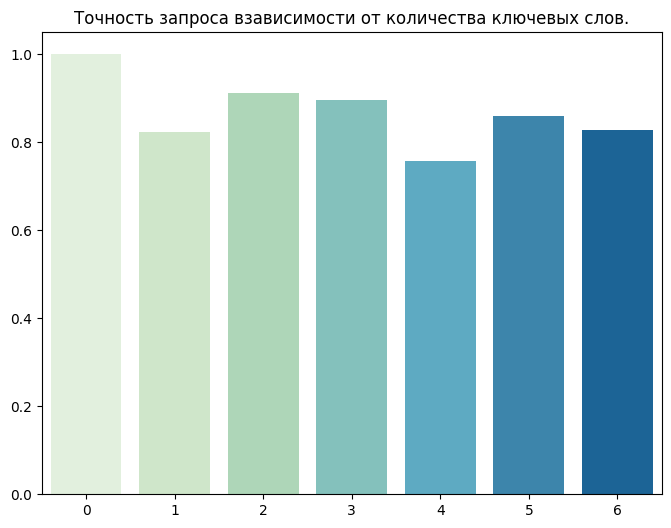

In [ ]:
by_kwords_accuracy_dct = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []}

for query, key_words, k_count in X_val.values:
    processed_query = model.transform(query, **best_params, verbose=False)
    
    if not processed_query:
        by_kwords_accuracy_dct[k_count].append(1 if key_words == ['None'] else 0)
        continue
    
    terms_selected = [q for q in processed_query.values() if q != 'None']
    terms_guessed = list(set([t for t in terms_selected if t in key_words]))
    by_kwords_accuracy_dct[k_count].append(len(terms_guessed)/k_count)

for i in by_kwords_accuracy_dct:
    by_kwords_accuracy_dct[i] = np.mean(by_kwords_accuracy_dct[i])
    
plt.figure(figsize=(8, 6))
sns.barplot(by_kwords_accuracy_dct, palette='GnBu')
plt.title('Точность запроса взависимости от количества ключевых слов.');

В разрезе длин предложений построим два графика: один показывает среднюю точность по raw accuracy, другой - по проценту угаданных слов.

{6: 0.8571428571428571, 17: 0.5555555555555556, 5: 0.9285714285714286, 4: 1.0, 10: 0.6842105263157895, 25: 0.6666666666666666, 15: 0.8888888888888888, 16: 0.46153846153846156, 9: 0.875, 20: 0.7, 19: 0.6153846153846154, 7: 0.9, 21: 1.0, 11: 0.7142857142857143, 13: 0.8, 18: 0.5454545454545454, 8: 0.8571428571428571, 12: 0.7272727272727273, 22: 0.8333333333333334, 3: 1.0, 14: 0.625, 28: 0.0}


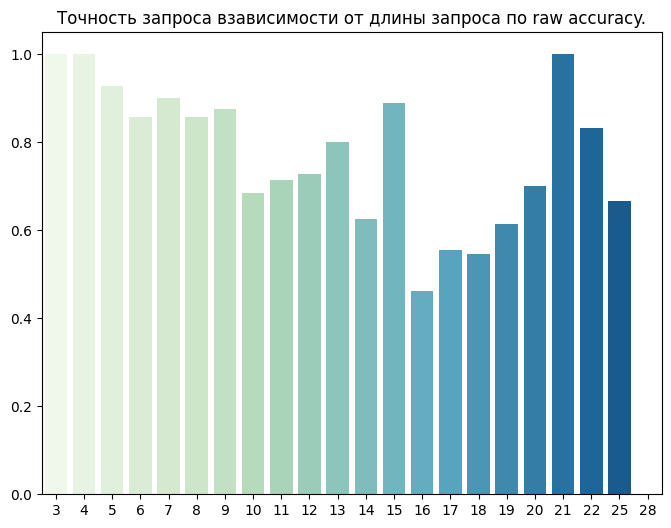

In [40]:
length_accuracy_dct = {}

for query, key_words, k_count in X_val.values:
    processed_query = model.transform(query, **best_params, verbose=False)
    query_length = len(query.split())
    if query_length not in length_accuracy_dct:
        length_accuracy_dct[query_length] = []
    
    if not processed_query:
        length_accuracy_dct[query_length].append(1 if key_words == ['None'] else 0)
        continue
    
    terms_selected = [q for q in processed_query.values() if q != 'None']
    
    length_accuracy_dct[query_length].append(set(terms_selected) == set(key_words))
    
for i in length_accuracy_dct:
    length_accuracy_dct[i] = np.mean(length_accuracy_dct[i])

print(length_accuracy_dct)
plt.figure(figsize=(8, 6))
sns.barplot(length_accuracy_dct, palette='GnBu')
plt.title('Точность запроса взависимости от длины запроса по raw accuracy.');

{6: 0.8571428571428571, 17: 0.7333333333333333, 5: 0.9285714285714286, 4: 1.0, 10: 0.7894736842105262, 25: 0.6666666666666666, 15: 0.8888888888888888, 16: 0.8871794871794871, 9: 0.875, 20: 0.9433333333333334, 19: 0.7256410256410256, 7: 0.9, 21: 1.0, 11: 0.9202380952380952, 13: 0.8800000000000001, 18: 0.746969696969697, 8: 0.9285714285714286, 12: 0.8606060606060606, 22: 0.8333333333333334, 3: 1.0, 14: 0.8020833333333333, 28: 0.0}


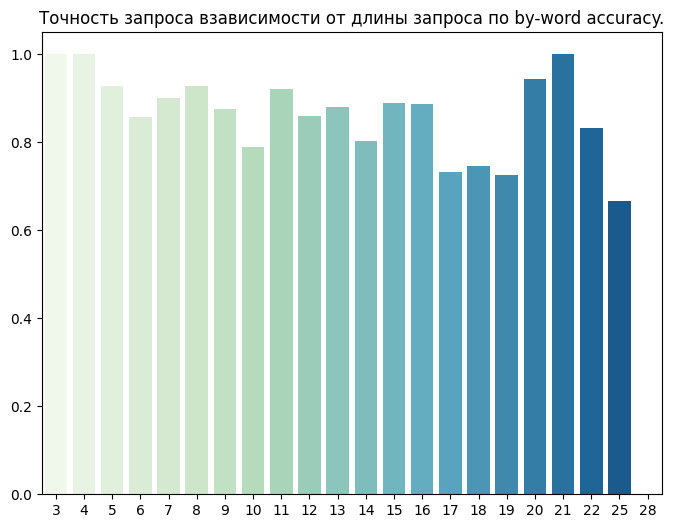

In [41]:
length_accuracy_dct = {}

for query, key_words, k_count in X_val.values:
    processed_query = model.transform(query, **best_params, verbose=False)
    query_length = len(query.split())
    if query_length not in length_accuracy_dct:
        length_accuracy_dct[query_length] = []
    
    if not processed_query:
        length_accuracy_dct[query_length].append(1 if key_words == ['None'] else 0)
        continue
    
    terms_selected = [q for q in processed_query.values() if q != 'None']
    terms_guessed = list(set([t for t in terms_selected if t in key_words]))
    
    length_accuracy_dct[query_length].append(len(terms_guessed)/k_count)
    
for i in length_accuracy_dct:
    length_accuracy_dct[i] = np.mean(length_accuracy_dct[i])

print(length_accuracy_dct)
plt.figure(figsize=(8, 6))
sns.barplot(length_accuracy_dct, palette='GnBu')
plt.title('Точность запроса взависимости от длины запроса по by-word accuracy.');

Как видим, результаты в целом неплохие. От количества слов в предложении какой-то явной корреляции нет.

# 5. Итоги и результаты

По итогам проделанной работы был получен алгоритм извлечения ключевых слов из запросов пользователей. Алгоритм  выполняет все требования, перечисленные в пункте "Задачи", отказоустойчив, обрабатывает все исключительные ситуации. Вдобавок, он оформлен в виде класса с удобными методами и подбираемыми гиперпараметрами, что позволяет удобно использовать и модифицировать его.
<br><br>
Результаты работы представлены в виде скриншотов небольшого сервиса и графиков точности с разными представлениями.